In [105]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import pandas as pd
from scipy import stats

In [123]:
def plot_loss(ax,
              x,
              y,
              label,
              num_epochs,
              num_batches_per_epoch,
              color,
              line_type,
              line_width):
    line_style = f"{color}{line_type}"

    # Given contastive-loss with cosine-similarity the expected range
    # of losses is 0 - 1
    ax.set_ylim(0.0001, 1.0)

    ax.plot(x, y, line_style, alpha=0.01,
            label=label, linewidth=line_width)

    # # Add epoch markers
    # for epoch in range(num_epochs):
    #     batch_idx = epoch * num_batches_per_epoch
    #     if batch_idx < len(y):
    #         ax.scatter(batch_idx, y[batch_idx],
    #                    color=color, alpha=0.5, marker='o')

In [91]:
def get_exps_data(base_path):
    exp_dirs = os.listdir(base_path)
    exp_data = {
        'Title': [],
        'Margin': [],
        'Initial Learning Rate': [],
        'Max Norm': [],
        'Losses': [],
        'Mean Losses': [],
        'Hedged Scores': [],
        'True Scores': []
    }
    for exp_dir in sorted(exp_dirs):
        exp_dir_path = os.path.join(base_path, exp_dir)
        if os.path.isdir(exp_dir_path):
            params_path = os.path.join(exp_dir_path, 'hyperparameters.json')
            assert os.path.exists(params_path)
            with open(params_path, 'r') as f:
                params = json.loads(f.read())
            exp_data['Title']\
                .append(f"M: {params['margin']:<04},"
                        f" LR: {params['initial_lr']},"
                        f" C: {params['max_norm']}")
            exp_data['Margin'].append(params['margin'])
            exp_data['Initial Learning Rate'].append(params['initial_lr'])
            exp_data['Max Norm'].append(params['max_norm'])
            losses_path = os.path.join(exp_dir_path,
                                       'undistorted',
                                       f"{exp_dir}_raw_losses.npy")
            assert os.path.exists(losses_path)
            losses = np.load(losses_path)
            exp_data['Losses'].append(losses)
            exp_data['Mean Losses'].append(np.mean(losses, axis=0))
            hedged_scores_path = os.path.join(exp_dir_path,
                                              'undistorted',
                                              f"{exp_dir}"
                                              "_all_eval_hedged_scores.csv")
            assert os.path.exists(hedged_scores_path)
            hedged_scores = pd.read_csv(hedged_scores_path,
                                        index_col=None)
            hedged_overall = hedged_scores['overall'].iloc[-1]
            hedged_sub_overall = hedged_scores['sub_overall'].iloc[-1]
            exp_data['Hedged Scores'].append((hedged_overall,
                                              hedged_sub_overall))

            true_scores_path = os.path.join(exp_dir_path,
                                            'undistorted',
                                            f"{exp_dir}"
                                            "_all_eval_true_scores.csv")
            assert os.path.exists(true_scores_path)
            true_scores = pd.read_csv(true_scores_path,
                                      index_col=None)
            true_overall = true_scores['overall'].iloc[-1]
            true_sub_overall = true_scores['overall'].iloc[-1]
            exp_data['True Scores'].append((true_overall,
                                            true_sub_overall))
    return exp_data

In [92]:
base_path = "/Users/zacbolton/dev/BSc/FP/historical_av_with_SBERT/saved_experiments/grid_search_margin_lr_clip"
exps_data = get_exps_data(base_path)

In [96]:
score_data = {}
targ_cols = [
    'Title',
    'Margin',
    'Initial Learning Rate',
    'Max Norm',
    'Hedged Scores',
    'True Scores'
]
val_data = {
    'Title': [],
    'Margin': [],
    'Initial Learning Rate': [],
    'Max Norm': [],
    'Hedged Scores (overall)': [],
    'Hedged Scores (sub_overall)': [],
    'True Scores (overall)': [],
    'True Scores (sub_overall)': []
}
for k in exps_data:
    if k in targ_cols:
        if k.endswith(' Scores'):
            if k.startswith('Hedged '):
                val_data['Hedged Scores (overall)'] = [i for i, j in exps_data[k]]
                val_data['Hedged Scores (sub_overall)'] = [j for i, j in exps_data[k]]
            elif k.startswith('True '):
                val_data['True Scores (overall)'] = [i for i, j in exps_data[k]]
                val_data['True Scores (sub_overall)'] = [j for i, j in exps_data[k]]
        else:
            val_data[k] = exps_data[k]

df_exp_data = pd.DataFrame(val_data)

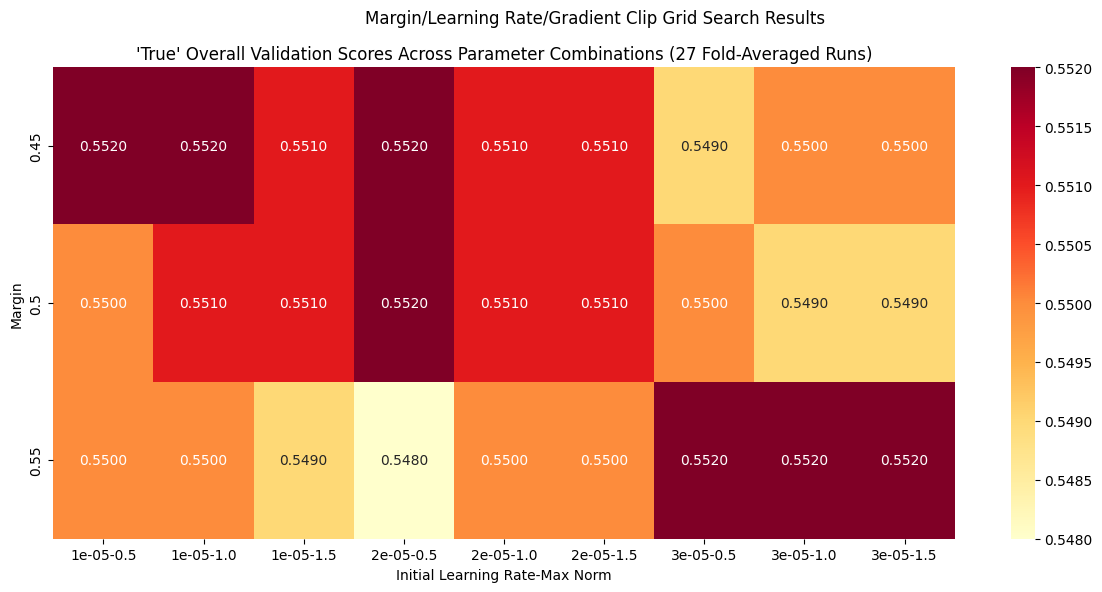


Pivot Table Structure:
Initial Learning Rate 0.00001               0.00002               0.00003  \
Max Norm                  0.5    1.0    1.5     0.5    1.0    1.5     0.5   
Margin                                                                      
0.45                    0.552  0.552  0.551   0.552  0.551  0.551   0.549   
0.50                    0.550  0.551  0.551   0.552  0.551  0.551   0.550   
0.55                    0.550  0.550  0.549   0.548  0.550  0.550   0.552   

Initial Learning Rate                
Max Norm                 1.0    1.5  
Margin                               
0.45                   0.550  0.550  
0.50                   0.549  0.549  
0.55                   0.552  0.552  


In [127]:
import seaborn as sns

pivot = df_exp_data.pivot_table(
    values='True Scores (overall)',
    index='Margin',
    columns=['Initial Learning Rate', 'Max Norm']
)

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(pivot, 
            annot=True,  # Show values in cells
            fmt='.4f',   # Format for the annotations
            cmap='YlOrRd',
            ax=ax)

plt.suptitle("Margin/Learning Rate/Gradient Clip Grid Search Results")
plt.title("'True' Overall Validation Scores Across Parameter Combinations (27 Fold-Averaged Runs)")

plt.tight_layout()

plt.show()

print("\nPivot Table Structure:")
print(pivot)

Slope: -7.99e-04
R-squared: 0.036
P-value: 2.222e-03
Slope: -6.01e-04
R-squared: 0.013
P-value: 1.129e-01
Slope: -2.75e-05
R-squared: 0.000
P-value: 9.698e-01
Slope: -2.04e-03
R-squared: 0.017
P-value: 3.040e-01


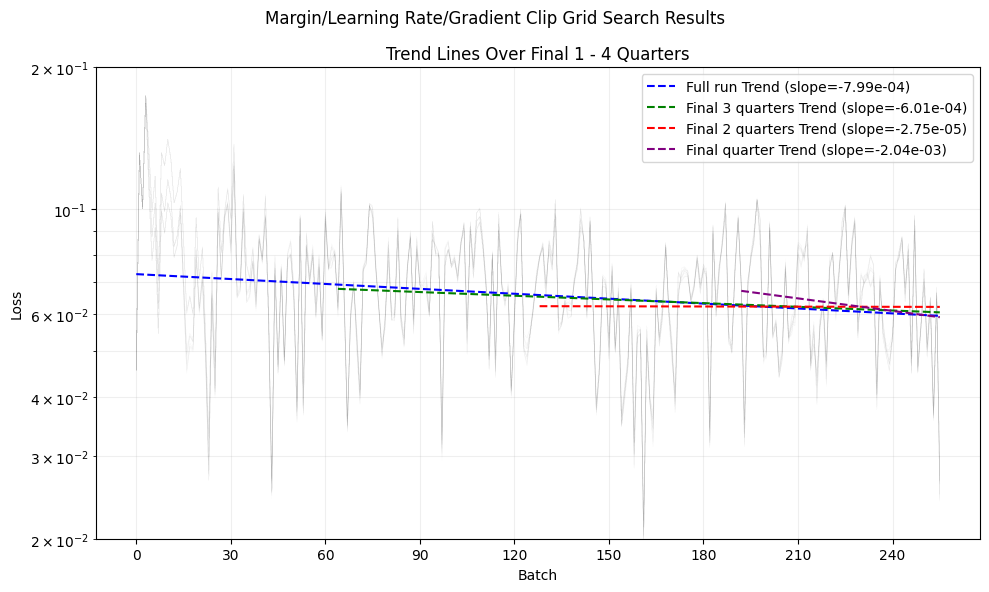

In [126]:
def plot_fit_line(q, batch_numbers, mean_losses, color):
    split_point = len(batch_numbers) // 4 * q
    x = batch_numbers[split_point:]
    y = mean_losses[split_point:]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))

    x_fit = np.linspace(split_point, max(batch_numbers), 100)
    y_fit = np.exp(slope * x_fit + intercept)
    if q == 0:
        label_prefix = "Full run"
    elif q == 3:
        label_prefix = "Final quarter"
    else:
        label_prefix = f"Final {4-q} quarters"
    plt.plot(x_fit, y_fit, '--', color=color, label=f'{label_prefix} Trend (slope={slope:.2e})')

    # Print statistics
    print(f"Slope: {slope:.2e}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.3e}")


fig, ax = plt.subplots(figsize=(10, 6))

num_epochs = exps_data['Losses'][-1].shape[0]
num_batches_per_epoch = exps_data['Losses'][-1].shape[1]

# margin_colors = {0.45: 'b', 0.5: 'g', 0.55: 'r'}
margin_colors = {0.45: 'k', 0.5: 'k', 0.55: 'k'}
for title, mean_losses, margin in zip(exps_data['Title'],
                                      exps_data['Mean Losses'],
                                      exps_data['Margin']):
    color = margin_colors[margin]
    batch_numbers = np.arange(len(mean_losses))
    plot_loss(ax, batch_numbers, mean_losses, None, num_epochs,
              num_batches_per_epoch, color, '-', 0.5)

plot_fit_line(0, batch_numbers, mean_losses, 'blue')
plot_fit_line(1, batch_numbers, mean_losses, 'green')
plot_fit_line(2, batch_numbers, mean_losses, 'red')
plot_fit_line(3, batch_numbers, mean_losses, 'purple')

ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.grid(True)
plt.suptitle("Margin/Learning Rate/Gradient Clip Grid Search Results")
# plt.title("Mean Losses Across Folds (27 Fold-Averaged Runs)")
plt.title("Trend Lines Over Final 1 - 4 Quarters")

# legend_elements = [
#     Line2D([0], [0], color='blue', label='margin=0.45'),
#     Line2D([0], [0], color='green', label='margin=0.50'),
#     Line2D([0], [0], color='red', label='margin=0.55')
# ]

# plt.legend(handles=legend_elements,
#            title='Grouped by margin value\n(9 runs each)',
#            bbox_to_anchor=(1.05, 1))
plt.legend()

# param_text = "Full parameter ranges:\n" + \
#              "learning rate: 1e-5, 2e-5, 3e-5\n" + \
#              "max norm: 0.5, 1.0, 1.5"
# plt.text(0.02, 0.98, param_text,
#          transform=ax.transAxes,
#          verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.yscale('log')
ax.set_ylim(0.02, 0.2)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()